In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path

base_name = "ngsa"

graph_dir = 'graphs'
graph_name = f'{base_name}.pt'
graph_dir = Path(graph_dir)
graph_dir.mkdir(exist_ok=True)
graph_path = graph_dir / graph_name

In [4]:
from pathlib import Path

from circuit_tracer import ReplacementModel, attribute
from circuit_tracer.utils import create_graph_files
from circuit_tracer.utils.create_graph_files import load_graph_data

graph = load_graph_data(graph_path)

In [5]:
from algorithm1 import run_ea_optimization
from experiments.models import EAHyperparameters

hp = EAHyperparameters(
    population_size=50,
    n_generations=50,
    w_completeness = 0.5,
    w_replacement = 1, 
    w_complexity_node = 8.0,
    w_complexity_edge = 4.0
)

result = run_ea_optimization(
  graph, 
  verbose=True, 
  max_batch_per_gpu=8,
  hp=hp,
)

MultiGPUGraphEvaluator initialized with 4 GPUs: [0, 1, 2, 3]
  Max batch per GPU: 8
Precomputing graph influence scores...
Starting NSGA-II Multi-Objective Evolutionary Algorithm...
Initialized population of size 50


/mnt/ffs24/home/moham147/experiments/circuit-tracer/experiments/evaluator.py:174: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at /pytorch/aten/src/ATen/native/BucketizationUtils.h:32.)
  cutoff_indices = torch.searchsorted(cum_fractions, layer_thresholds)


Initial evaluation complete.
Sample individual objectives: [0.9985535740852356, 117.40856130626939]
Number of fronts: 6
Front 0 size: 15

=== Generation 1/50 ===
Pareto front size: 15
Best quality individual:
  Rank: 0 | Crowding Distance: inf
  Objectives: Quality=1.0775, Complexity=124.1835
  Completeness: 0.8951 | Replacement: 0.6299
  Nodes: 3956 (log: 8.28) | Edges: 1943276 (log: 14.48)
  Mean Node Threshold: 0.7918 | Mean Edge Threshold: 0.7197
  Overrides: +0/-0 nodes, +0/-0 edges

=== Generation 2/50 ===
Pareto front size: 20
Best quality individual:
  Rank: 0 | Crowding Distance: inf
  Objectives: Quality=1.0938, Complexity=131.1230
  Completeness: 0.8974 | Replacement: 0.6451
  Nodes: 5039 (log: 8.52) | Edges: 6789127 (log: 15.73)
  Mean Node Threshold: 0.7824 | Mean Edge Threshold: 0.7140
  Overrides: +0/-0 nodes, +0/-0 edges

=== Generation 3/50 ===
Pareto front size: 14
Best quality individual:
  Rank: 0 | Crowding Distance: inf
  Objectives: Quality=1.0938, Complexity=131

In [6]:
# evaluate default graph

In [7]:
# Examine NSGA-II results
print(f"Pareto Front Size: {result['pareto_front_size']}")
print()

# Best quality solution (max completeness + replacement)
print("=== Best Quality Solution ===")
bq = result['best_quality']
print(f"  Quality: {bq['quality']:.4f}, Complexity: {bq['complexity']:.4f}")
print(f"  Completeness: {bq['completeness']:.4f}, Replacement: {bq['replacement']:.4f}")
print(f"  Nodes: {bq['n_nodes']}, Edges: {bq['n_edges']}")

# Best complexity solution (min nodes + edges)
print("\n=== Best Complexity Solution ===")
bc = result['best_complexity']
print(f"  Quality: {bc['quality']:.4f}, Complexity: {bc['complexity']:.4f}")
print(f"  Completeness: {bc['completeness']:.4f}, Replacement: {bc['replacement']:.4f}")
print(f"  Nodes: {bc['n_nodes']}, Edges: {bc['n_edges']}")

# Balanced solution (knee point)
print("\n=== Balanced Solution (Knee Point) ===")
bal = result['balanced']
print(f"  Quality: {bal['quality']:.4f}, Complexity: {bal['complexity']:.4f}")
print(f"  Completeness: {bal['completeness']:.4f}, Replacement: {bal['replacement']:.4f}")
print(f"  Nodes: {bal['n_nodes']}, Edges: {bal['n_edges']}")

Pareto Front Size: 46

=== Best Quality Solution ===
  Quality: 1.1518, Complexity: 117.5697
  Completeness: 0.9059, Replacement: 0.6988
  Nodes: 2643, Edges: 833248

=== Best Complexity Solution ===
  Quality: 1.0279, Complexity: 94.5923
  Completeness: 0.8702, Replacement: 0.5928
  Nodes: 677, Edges: 40649

=== Balanced Solution (Knee Point) ===
  Quality: 1.0975, Complexity: 98.7799
  Completeness: 0.8865, Replacement: 0.6543
  Nodes: 807, Edges: 81498


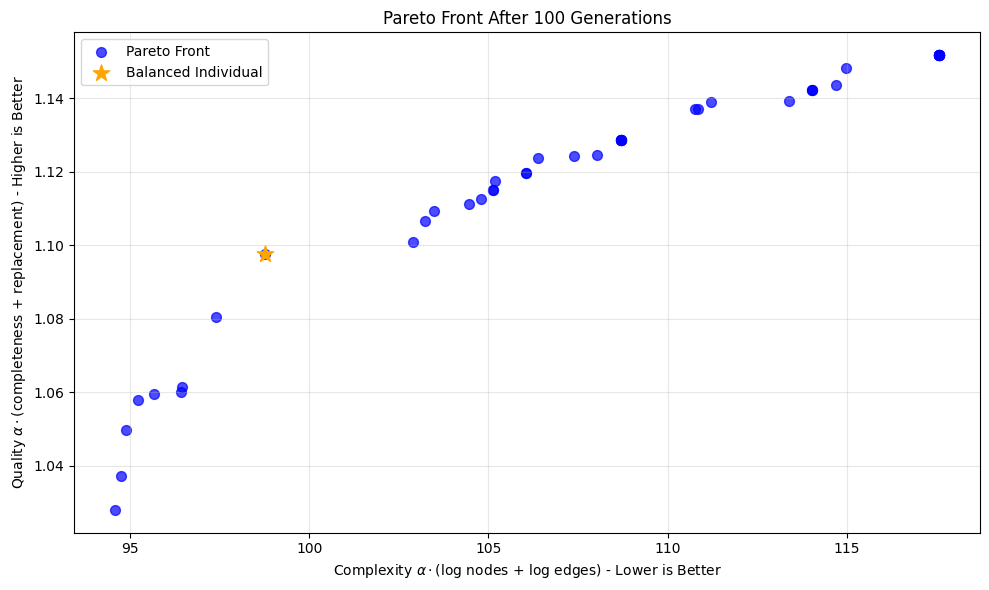

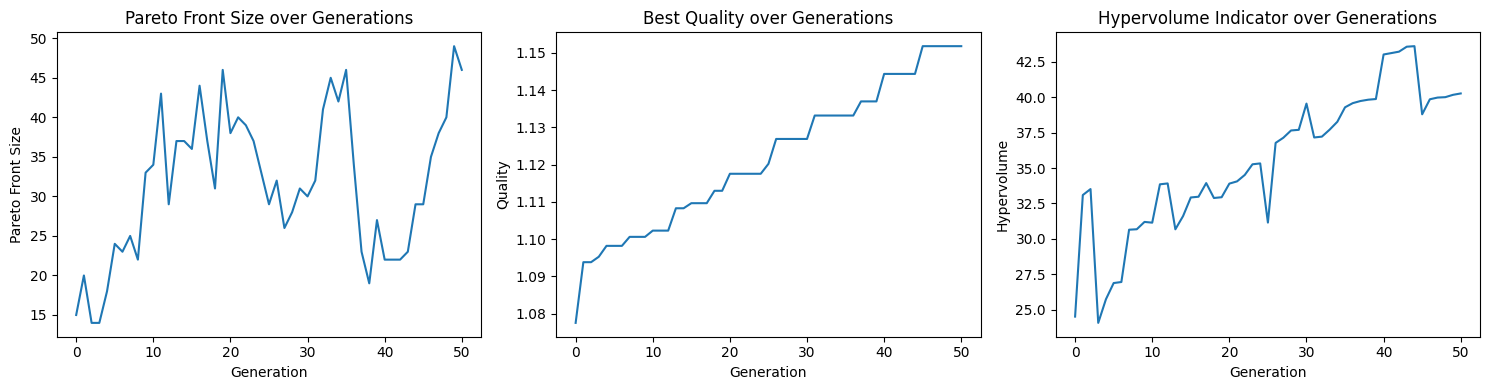

In [8]:
# Plot Pareto Front
import matplotlib.pyplot as plt

pareto = result['pareto_front']
qualities = [p['quality'] for p in pareto]
complexities = [p['complexity'] for p in pareto]

plt.figure(figsize=(10, 6))
plt.scatter(complexities, qualities, c='blue', s=50, alpha=0.7, label='Pareto Front')

# Highlight special solutions
# plt.scatter([result['best_quality']['complexity']], [result['best_quality']['quality']], 
#             c='green', s=150, marker='*', label='Best Quality', zorder=5)
# plt.scatter([result['best_complexity']['complexity']], [result['best_complexity']['quality']], 
#             c='red', s=150, marker='*', label='Best Complexity', zorder=5)
plt.scatter([result['balanced']['complexity']], [result['balanced']['quality']], 
            c='orange', s=150, marker='*', label='Balanced Individual', zorder=5)

plt.xlabel('Complexity $\\alpha\\cdot$(log nodes + log edges) - Lower is Better')
plt.ylabel('Quality $\\alpha\\cdot$(completeness + replacement) - Higher is Better')
plt.title("Pareto Front After 100 Generations")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot convergence history
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

history = result['history']
axes[0].plot(history['generation'], history['pareto_front_size'])
axes[0].set_xlabel('Generation')
axes[0].set_ylabel('Pareto Front Size')
axes[0].set_title('Pareto Front Size over Generations')

axes[1].plot(history['generation'], history['best_quality'], label='Best Quality')
axes[1].set_xlabel('Generation')
axes[1].set_ylabel('Quality')
axes[1].set_title('Best Quality over Generations')

axes[2].plot(history['generation'], history['hypervolume'])
axes[2].set_xlabel('Generation')
axes[2].set_ylabel('Hypervolume')
axes[2].set_title('Hypervolume Indicator over Generations')

plt.tight_layout()
plt.show()

In [9]:
# Create graph files from EA result
from experiments.create_graph_files_ea import create_graph_files_from_ea_result

slug = f"{base_name}_ea"
graph_file_dir = './graph_files'

create_graph_files_from_ea_result(
    graph_or_path=graph,
    ea_result=result['best_complexity'],
    slug=slug,
    output_path=graph_file_dir
)

print(f"Graph files created in {graph_file_dir}/{slug}.json")

# Create graph files (baseline, default pruning)
slug = f"{base_name}_baseline"  # this is the name that you assign to the graph
graph_file_dir = './graph_files'  # where to write the graph files. no need to make this one; create_graph_files does that for you
node_threshold=0.8  # keep only the minimum # of nodes whose cumulative influence is >= 0.8
edge_threshold=0.98  # keep only the minimum # of edges whose cumulative influence is >= 0.98

create_graph_files(
    graph_or_path=graph,
    slug=slug,
    output_path=graph_file_dir,
    node_threshold=node_threshold,
    edge_threshold=edge_threshold
)
print(f"Graph files created in {graph_file_dir}/{slug}.json")


Graph files created in ./graph_files/ngsa_ea.json
pruning graph
Graph files created in ./graph_files/ngsa_baseline.json


In [10]:
# evaluate baseline graph
from circuit_tracer.graph import compute_graph_scores_masked, prune_graph

node_mask, edge_mask, cumulative_scores = prune_graph(graph, node_threshold, edge_threshold)
print(f"Baseline pruned graph scores:   {compute_graph_scores_masked(graph, node_mask, edge_mask)}")

pruning graph
Baseline pruned graph scores:   (0.578798770904541, 0.8821017742156982)


In [18]:
from experiments.algorithm1 import GraphPrunerEA, create_individual
import torch

ea = GraphPrunerEA(graph, hp)

# Create an individual with uniform thresholds matching prune_graph settings
# node_threshold=0.8, edge_threshold=0.98 from cell 11
n_layers = graph.cfg.n_layers
device = graph.adjacency_matrix.device

individual = create_individual(
    node_thresholds=[node_threshold] * n_layers,  # 0.8 for all layers
    edge_thresholds=[edge_threshold] * n_layers,  # 0.98 for all layers
    device=device
)

# Evaluate the individual
ea.evaluate(individual)

print(f"Individual based on prune_graph thresholds:")
print(f"  Node threshold: {node_threshold}, Edge threshold: {edge_threshold}")
print(f"  Quality: {individual.objectives[0]:.4f}, Complexity: {individual.objectives[1]:.4f}")
print(f"  Completeness: {individual.completeness:.4f}, Replacement: {individual.replacement:.4f}")
print(f"  Nodes: {individual.n_nodes}, Edges: {individual.n_edges}")

MultiGPUGraphEvaluator initialized with 4 GPUs: [0, 1, 2, 3]
  Max batch per GPU: 8
Precomputing graph influence scores...
Precomputing graph influence scores...
Individual based on prune_graph thresholds:
  Node threshold: 0.8, Edge threshold: 0.98
  Quality: 1.0692, Complexity: 125.8513
  Completeness: 0.8975, Replacement: 0.6205
  Nodes: 3725, Edges: 3325656
Individual based on prune_graph thresholds:
  Node threshold: 0.8, Edge threshold: 0.98
  Quality: 1.0692, Complexity: 125.8513
  Completeness: 0.8975, Replacement: 0.6205
  Nodes: 3725, Edges: 3325656


In [11]:
from circuit_tracer.frontend.local_server import serve

port = 8194
server = serve(data_dir='./graph_files/', port=port)

from IPython.display import IFrame
display(IFrame(src=f'http://localhost:{port}/index.html', width='100%', height='800px'))


OSError: [Errno 98] Address already in use

In [ ]:
server.stop()